<a href="https://colab.research.google.com/github/shivi13102/Earthquake_analysis/blob/main/Eda_FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

In [ ]:
df1 = pd.read_csv("/content/merged_table1.csv") # Normalized
df2 = pd.read_csv("/content/merged_table2.csv") # Not Normalized

# Exploratory Data Analysis (EDA)

# Time-series analysis for seismic activity patterns

## 1. Yearly Trend

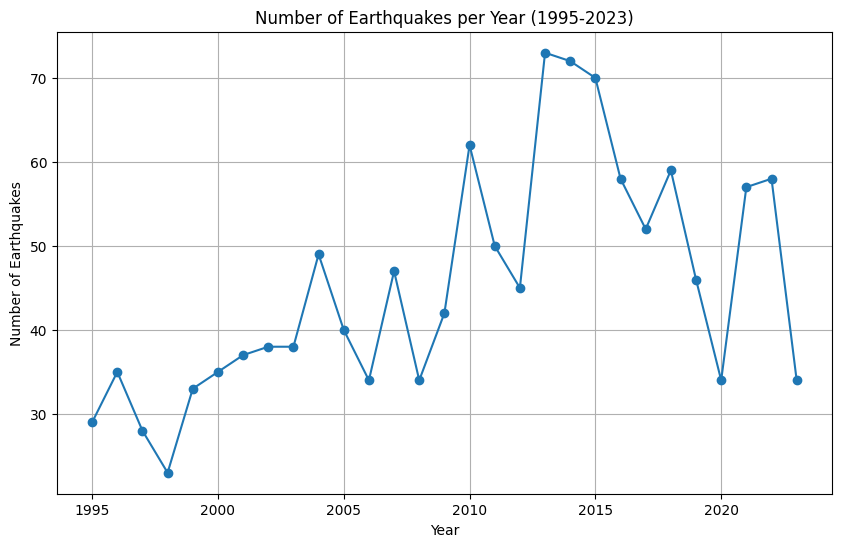

In [ ]:
# Assuming the dataframe is called 'df' and contains 'date_time' and 'magnitude' columns
df1['date_time'] = pd.to_datetime(df1['date_time'])

# Extract year for time-series analysis
df1['year'] = df1['date_time'].dt.year

# Count the number of earthquakes per year
earthquakes_per_year = df1.groupby('year').size()

# Plot the time-series of seismic activity
plt.figure(figsize=(10, 6))
plt.plot(earthquakes_per_year.index, earthquakes_per_year.values, marker='o')
plt.title('Number of Earthquakes per Year (1995-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid(True)
plt.show()

## 2. Monthly Trend

<Figure size 1200x800 with 0 Axes>

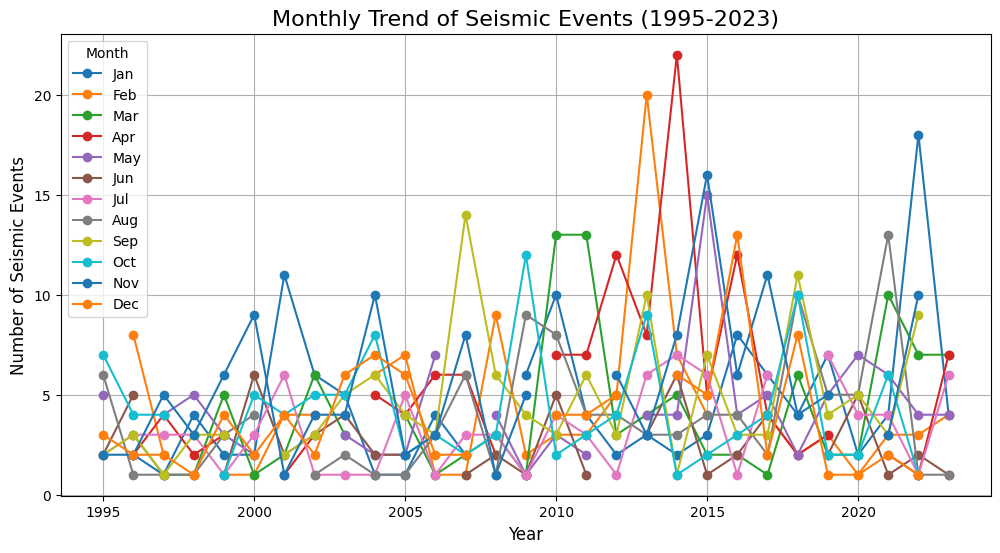

In [ ]:
# Extract the year and month from the 'date_time' column
df1['year'] = df1['date_time'].dt.year
df1['month'] = df1['date_time'].dt.month

# Count the number of events per month (grouped by year and month)
monthly_trend = df1.groupby(['year', 'month']).size().reset_index(name='event_count')

# Pivot the data to get a year-month matrix for easier visualization
monthly_trend_pivot = monthly_trend.pivot(index='year', columns='month', values='event_count')

# Plot the monthly trend (events per month for each year)
plt.figure(figsize=(12, 8))
monthly_trend_pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Monthly Trend of Seismic Events (1995-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Seismic Events', fontsize=12)
plt.grid(True)
plt.legend(title='Month', labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Magnitude distributions

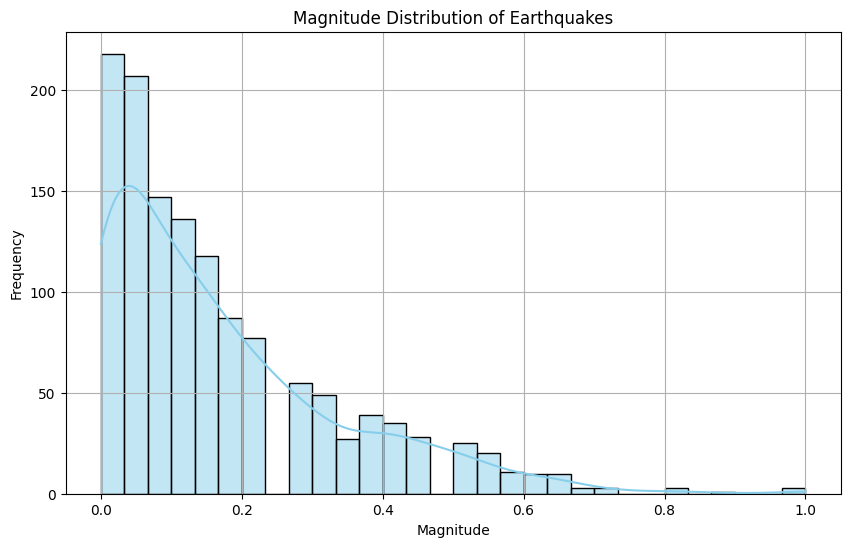

In [ ]:
# Histogram of earthquake magnitudes
plt.figure(figsize=(10, 6))
sns.histplot(df1['magnitude'], bins=30, kde=True, color='skyblue')
plt.title('Magnitude Distribution of Earthquakes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

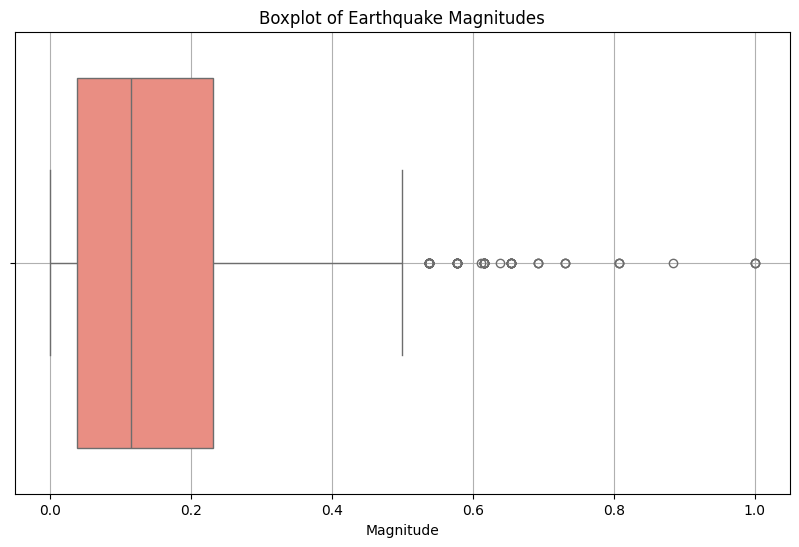

In [ ]:
# Boxplot of earthquake magnitudes for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df1['magnitude'], color='salmon')
plt.title('Boxplot of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.grid(True)
plt.show()

# Correlation Analysis

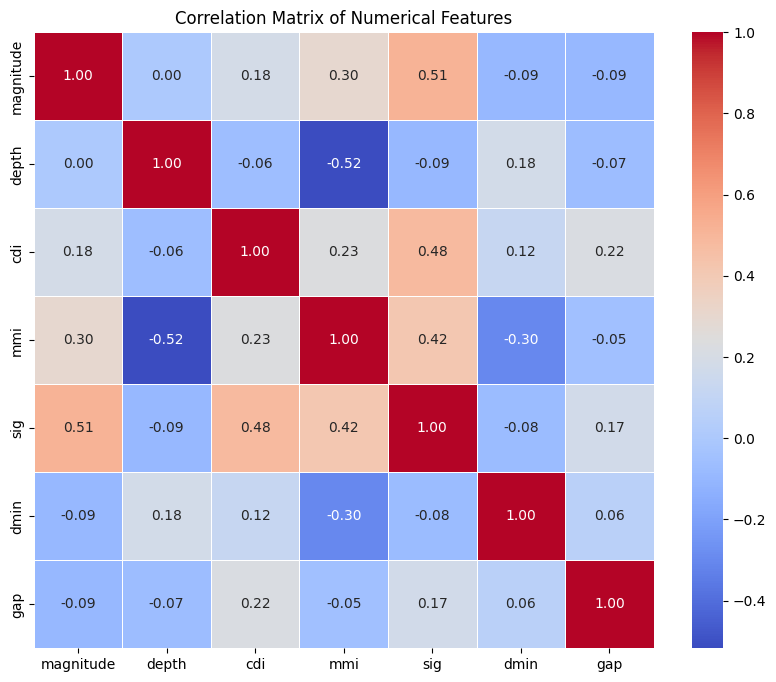

In [ ]:
# Select numerical columns for correlation
numerical_cols = ['magnitude', 'depth', 'cdi', 'mmi', 'sig', 'dmin', 'gap']

# Calculate correlation matrix
correlation_matrix = df1[numerical_cols].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

1. Strong Positive Correlation between Magnitude and these Features:
* cdi (Community Internet Intensity): This indicates that larger earthquakes are generally perceived as more intense by the public.
* mmi (Modified Mercalli Intensity): A higher magnitude earthquake will likely result in a higher perceived intensity on the Mercalli scale.
* sig (Significant): Larger earthquakes are more likely to be classified as significant events.
Depth and Intensity Relationship:

2. Moderate negative correlation between depth and mmi (Modified Mercalli Intensity): This suggests that shallower earthquakes tend to have a higher perceived intensity at the surface.
Depth and Magnitude Correlation:

3. Correlation between depth and magnitude is weak: This indicates that the magnitude of an earthquake is not strongly influenced by its depth.

# Spatial Patterns

Plotting the high-seismicity regions on the map

<Axes: >

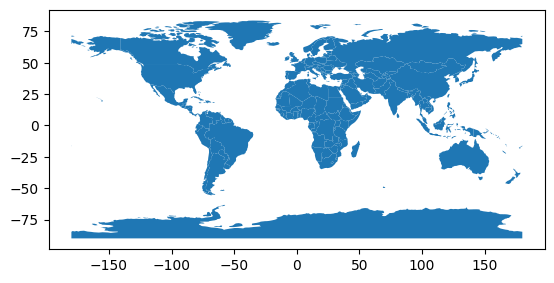

In [ ]:
shapefile_path = '/content/ne_110m_admin_0_countries.shp'

# Load the shapefile
world = gpd.read_file(shapefile_path)

# Now you can plot or work with the `world` GeoDataFrame as needed
world.plot()

In [ ]:
# Create a GeoDataFrame with the earthquake locations
gdf = gpd.GeoDataFrame(df2,
                       geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']),
                       crs="EPSG:4326")

# Plot high-seismicity regions using plotly
fig = px.scatter_geo(gdf,
                     lat='latitude', lon='longitude',
                     color='magnitude',
                     hover_name='title',
                     title='High-Seismicity Regions (Magnitude)',
                     color_continuous_scale='Viridis',
                     projection="natural earth")

fig.update_geos(showland=True, landcolor="white", showcoastlines=True, coastlinecolor="Black")
fig.update_layout(title="Global Earthquake Seismicity (Magnitude)")
fig.show()

# Tsunami Analysis

Plotting the earthquakes that had a tsunami (Tsunami Indicator = 1)

In [ ]:
# Filter for earthquakes with Tsunami Indicator = 1
tsunami_events = df2[df2['tsunami'] == 1]

# Plot tsunami-prone areas using a scatter plot on the world map
fig = px.scatter_geo(tsunami_events,
                     lat='latitude', lon='longitude',
                     color='magnitude',
                     hover_name='title',
                     title='Tsunami-Prone Earthquakes',
                     color_continuous_scale='Inferno',
                     projection="natural earth")

fig.update_geos(showland=True, landcolor="white", showcoastlines=True, coastlinecolor="Black")
fig.update_layout(title="Tsunami-Prone Earthquakes (Tsunami Indicator = 1)")
fig.show()


# Feature Engineering


##1. Earthquake Frequency

Total Earthquakes in a Time Period by Country

In [ ]:
# Convert date to datetime format
df2['date_time'] = pd.to_datetime(df2['date_time'])

# Extract year and month from the date
df2['year'] = df2['date_time'].dt.year
df2['month'] = df2['date_time'].dt.month

# Group by country, year, and month, then count the number of earthquakes
earthquake_frequency = df2.groupby(['country', 'year', 'month']).size().reset_index(name='earthquake_count')

# You can merge this with your original dataframe if you want to use this feature later in analysis
df = df2.merge(earthquake_frequency, on=['country', 'year', 'month'], how='left')

## 2. Earthquake Intensity

In [ ]:
# Assuming the normalized magnitude is in the range [0, 1]
df2['earthquake_intensity'] = pd.cut(df['magnitude'], bins=[0, 0.4, 0.7, 1], labels=['Weak', 'Moderate', 'Strong'])

# You can also count how many strong earthquakes there were in a given time period
strong_earthquakes = df2[df2['earthquake_intensity'] == 'Strong']
strong_earthquakes_count = strong_earthquakes.groupby(['country', 'year', 'month']).size().reset_index(name='strong_earthquake_count')

# Merge with the original dataframe
df2 = df.merge(strong_earthquakes_count, on=['country', 'year', 'month'], how='left')

In [ ]:
df

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,...,depth,latitude,longitude,location,country,year,month,earthquake_count,earthquake_intensity,strong_earthquake_count
0,"M 6.5 - 42 km W of Sola, Vanuatu",0.000000,2023-08-16 12:47:00,0.777778,0.333333,green,0.0,0.003097,us,0.122056,...,0.284766,0.359358,0.965231,"Sola, Vanuatu",Vanuatu,2023,8,1.0,NaN,NaN
1,"M 6.5 - 43 km S of Intipucá, El Salvador",0.000000,2023-07-19 00:22:00,0.888889,0.555556,yellow,0.0,0.055310,us,0.098501,...,0.100323,0.559354,0.255378,"Intipucá, El Salvador",Indonesia,2023,7,5.0,NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",0.038462,2023-07-17 03:05:00,0.777778,0.444444,green,0.0,0.110177,us,0.074946,...,0.252460,0.177235,0.304743,"Loncopué, Argentina",Argentina,2023,7,1.0,Weak,NaN
3,"M 7.2 - 98 km S of Sand Point, Alaska",0.269231,2023-07-16 06:48:00,0.666667,0.555556,green,1.0,0.092920,us,0.185225,...,0.044710,0.870791,0.053580,"Sand Point, Alaska",Indonesia,2023,7,5.0,Weak,NaN
4,M 7.3 - Alaska Peninsula,0.307692,2023-07-16 06:48:00,0.000000,0.444444,NaN,1.0,0.075221,at,0.084582,...,0.027391,0.871582,0.053310,Alaska Peninsula,Indonesia,2023,7,5.0,Weak,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,"M 7.1 - 85 km S of Tungor, Russia",0.230769,1995-05-27 13:03:00,0.000000,0.888889,NaN,0.0,0.055752,us,0.000000,...,0.012423,0.857640,0.897575,"Tungor, Russia",Russia,1995,5,1.0,Weak,NaN
1308,"M 7.7 - 249 km E of Vao, New Caledonia",0.461538,1995-05-16 20:12:00,0.000000,0.333333,NaN,0.0,0.115929,us,0.000000,...,0.026193,0.290984,0.972855,"Vao, New Caledonia",Indonesia,1995,5,2.0,Moderate,NaN
1309,"M 6.9 - 27 km NNW of Maubara, Timor Leste",0.153846,1995-05-14 11:33:00,0.000000,0.555556,NaN,0.0,0.036283,us,0.000000,...,0.012722,0.400589,0.848358,"Maubara, Timor Leste",Indonesia,1995,5,2.0,Weak,NaN
1310,"M 6.6 - 10 km W of Aianí, Greece",0.038462,1995-05-13 08:47:00,0.000000,0.888889,NaN,0.0,0.008850,us,0.000000,...,0.016913,0.764142,0.560751,"Aianí, Greece",Greece,1995,5,1.0,Weak,NaN


In [ ]:
# Save the merged DataFrame to a CSV file
file_name = '/content/df2.csv'
df2.to_csv(file_name, index=False)

# Provide a link to download the file
from google.colab import files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>